In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
from tqdm import tqdm
from datasets import load_from_disk
from PIL import Image

# Define the MRL components from the code base
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=1000, efficient=False, emb_eval = False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        self.emb_eval = emb_eval
        
        if self.efficient:
            setattr(self, f"nesting_classifier_{0}", nn.Linear(nesting_list[-1], self.num_classes, **kwargs))
        else:    
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))    

    def reset_parameters(self):
        if self.efficient:
            self.nesting_classifier_0.reset_parameters()
        else:
            for i in range(len(self.nesting_list)):
                getattr(self, f"nesting_classifier_{i}").reset_parameters()

    def forward(self, x):
        nesting_logits = ()
        if self.emb_eval:
            nesting_embeddings = []
        for i, num_feat in enumerate(self.nesting_list):
            if self.emb_eval:
                nesting_embeddings.append(x[:, :num_feat])
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        if self.emb_eval:
            return nesting_embeddings, nesting_logits
        return nesting_logits

class BlurPoolConv2d(nn.Module):
    def __init__(self, conv):
        super().__init__()
        default_filter = torch.tensor([[[[1, 2, 1], [2, 4, 2], [1, 2, 1]]]]) / 16.0
        filt = default_filter.repeat(conv.in_channels, 1, 1, 1)
        self.conv = conv
        self.register_buffer('blur_filter', filt)

    def forward(self, x):
        blurred = F.conv2d(x, self.blur_filter, stride=1, padding=(1, 1),
                           groups=self.conv.in_channels, bias=None)
        return self.conv.forward(blurred)

/home/davinci/miniconda3/envs/mrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def apply_blurpool(mod: nn.Module):
    for (name, child) in mod.named_children():
        if isinstance(child, nn.Conv2d) and (np.max(child.stride) > 1 and child.in_channels >= 16):
            setattr(mod, name, BlurPoolConv2d(child))
        else: 
            apply_blurpool(child)

In [3]:
def load_model(model_path, emb_eval):
    # Model configuration
    nesting_start = 3
    efficient = True
    nesting_list = [2**i for i in range(nesting_start, 12)]  # 8, 16, 32, 64, 128, 256, 512, 1024, 2048
    num_classes = 1000
    
    # Create the model
    print("Initializing ResNet50 model...")
    model = models.resnet50(pretrained=True)
    model.fc = MRL_Linear_Layer(nesting_list, num_classes=num_classes, efficient=efficient, emb_eval=emb_eval)
    
    # Apply BlurPool to the model
    print("Applying BlurPool...")
    apply_blurpool(model)
    
    # Load the pretrained weights
    try:
        print(f"Loading weights from {model_path}...")
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Handle case where weights were saved in DataParallel format
        if list(checkpoint.keys())[0].startswith('module.'):
            # Remove 'module.' prefix
            clean_ckpt = {}
            for k, v in checkpoint.items():
                clean_ckpt[k[7:] if k.startswith('module.') else k] = v
            checkpoint = clean_ckpt
        
        model.load_state_dict(checkpoint)
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Continuing with pretrained weights only.")
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = model.to(memory_format=torch.channels_last)
    model.eval()
    
    return model, nesting_list, device

In [4]:
def evaluate_dataset(model, dataset, nesting_list, device, batch_size=64, num_samples=None):
    # Standard ImageNet normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    # Create transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    
    # Initialize accuracy trackers for each embedding dimension
    correct_top1 = {dim: 0 for dim in nesting_list}
    correct_top5 = {dim: 0 for dim in nesting_list}
    
    # Limit samples if specified
    if num_samples is not None:
        total_samples = min(num_samples, len(dataset))
    else:
        total_samples = len(dataset)
    
    # Process in batches
    batches = []
    labels = []
    
    print(f"Processing {total_samples} images...")
    for i in tqdm(range(0, total_samples, batch_size)):
        batch_indices = range(i, min(i + batch_size, total_samples))
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            
            # Apply transformations
            img_tensor = transform(image)
            batch_images.append(img_tensor)
            batch_labels.append(label)
        
        # Stack into a batch tensor
        images_tensor = torch.stack(batch_images).to(device)
        labels_tensor = torch.tensor(batch_labels).to(device)
        
        # Convert to channels last format for better performance
        images_tensor = images_tensor.to(memory_format=torch.channels_last)
        
        # Forward pass
        with torch.no_grad():
            outputs = model(images_tensor)
        
        # Calculate accuracy for each embedding dimension
        for j, dim in enumerate(nesting_list):
            # Top-1 accuracy
            _, predicted = outputs[j].max(1)
            correct_top1[dim] += (predicted == labels_tensor).sum().item()
            
            # Top-5 accuracy
            _, top5_indices = outputs[j].topk(5, dim=1)
            labels_expanded = labels_tensor.view(-1, 1).expand_as(top5_indices)
            correct_top5[dim] += (top5_indices == labels_expanded).sum().item()
    
    # Calculate final accuracy for each dimension
    accuracy_top1 = {dim: correct_top1[dim] / total_samples * 100 for dim in nesting_list}
    accuracy_top5 = {dim: correct_top5[dim] / total_samples * 100 for dim in nesting_list}
    
    return accuracy_top1, accuracy_top5, total_samples

In [5]:
def evaluate_embeddings(model, dataset, nesting_list, device, batch_size=64, num_samples=None):
    # Standard ImageNet normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    # Create transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])
    
    # Initialize storage for embeddings and labels
    embeddings_dict = {dim: [] for dim in nesting_list}
    all_labels = []
    
    # Limit samples if specified
    if num_samples is not None:
        total_samples = min(num_samples, len(dataset))
    else:
        total_samples = len(dataset)
    
    print(f"Extracting embeddings from {total_samples} images...")
    for i in tqdm(range(0, total_samples, batch_size)):
        batch_indices = range(i, min(i + batch_size, total_samples))
        batch_images = []
        batch_labels = []
        
        # Process each image in the batch
        for idx in batch_indices:
            sample = dataset[idx]
            image = sample['image']
            label = sample['label']
            
            # Apply transformations
            img_tensor = transform(image)
            batch_images.append(img_tensor)
            batch_labels.append(label)
        
        # Stack into batch tensors
        images_tensor = torch.stack(batch_images).to(device)
        labels_tensor = torch.tensor(batch_labels).to(device)
        
        # Convert to channels last format
        images_tensor = images_tensor.to(memory_format=torch.channels_last)
        
        # Forward pass to get embeddings
        with torch.no_grad():
            batch_embeddings, _ = model(images_tensor)  # Ignore logits
            
        # Store embeddings and labels
        for dim_idx, dim in enumerate(nesting_list):
            # Move embeddings to CPU and detach from computation graph
            embeddings_dict[dim].append(
                batch_embeddings[dim_idx].detach().cpu()
            )
        all_labels.append(labels_tensor.cpu())
    
    # Concatenate all batches
    for dim in nesting_list:
        embeddings_dict[dim] = torch.cat(embeddings_dict[dim], dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return embeddings_dict, all_labels

In [6]:
# Configuration
model_path = "weights/final_weights.pt"
val_dataset_path = "data/imagenet_1k_resized_256_val"
batch_size = 512  # Adjust based on your GPU memory
num_samples = None  # Set to None to process all images, or a number to limit samples

# Load model
model, nesting_list, device = load_model(model_path, emb_eval=True)

# Load datasets
print(f"Loading val dataset from {val_dataset_path}...")
val_dataset = load_from_disk(val_dataset_path)
print(f"Val dataset loaded with {len(val_dataset)} samples")

# # Evaluate the model on the dataset
# accuracy_top1, accuracy_top5, total_samples = evaluate_dataset(
#     model, dataset, nesting_list, device, batch_size, num_samples
# )

# # Print results
# print(f"\nEvaluation completed on {total_samples} images")
# print("\nAccuracy results for each embedding dimension:")
# print(f"{'Embedding Dim':<15} {'Top-1 Accuracy (%)':<20} {'Top-5 Accuracy (%)'}")
# print("-" * 60)

# for dim in nesting_list:
#     print(f"{dim:<15} {accuracy_top1[dim]:<20.2f} {accuracy_top5[dim]:<20.2f}")

# # Print a summary for the best dimension
# best_dim = max(accuracy_top1, key=accuracy_top1.get)
# print(f"\nBest performing dimension: {best_dim}")
# print(f"Top-1 Accuracy: {accuracy_top1[best_dim]:.2f}%")
# print(f"Top-5 Accuracy: {accuracy_top5[best_dim]:.2f}%")

Initializing ResNet50 model...


/home/davinci/miniconda3/envs/mrl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davinci/miniconda3/envs/mrl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Applying BlurPool...
Loading weights from weights/final_weights.pt...
Model loaded successfully!
Loading val dataset from data/imagenet_1k_resized_256_val...
Val dataset loaded with 50000 samples


In [7]:
val_emb, val_labels = evaluate_embeddings(
    model, val_dataset, nesting_list, device, batch_size, num_samples
)

Extracting embeddings from 50000 images...


100%|██████████| 98/98 [02:13<00:00,  1.36s/it]


In [8]:
val_emb[2048].shape, val_emb[128].shape

(torch.Size([50000, 2048]), torch.Size([50000, 128]))

Custom splitting function that preserves class balance.

In [9]:
from collections import defaultdict
from sklearn.utils import shuffle

def stratified_embedding_split(embeddings, labels, test_size=0.2, random_state=None):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Create class-index mapping
    class_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        class_indices[label].append(idx)

    train_indices = []
    test_indices = []

    for class_label, indices in class_indices.items():
        n_samples = len(indices)
        n_test = max(1, int(n_samples * test_size))  # Ensure at least 1 sample per class


        np.random.seed(random_state)
        shuffled_indices = shuffle(indices, random_state=random_state)
        class_test = shuffled_indices[:n_test]
        class_train = shuffled_indices[n_test:]
        
        test_indices.extend(class_test)
        train_indices.extend(class_train)

    np.random.seed(random_state)
    train_indices = shuffle(train_indices, random_state=random_state)
    test_indices = shuffle(test_indices, random_state=random_state)

    X_train = embeddings[train_indices]
    X_test = embeddings[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    return X_train, X_test, y_train, y_test

In [10]:
val_emb

{8: tensor([[1.4059, 1.2499, 1.8584,  ..., 3.3244, 4.2899, 4.1955],
         [0.4065, 0.2182, 2.1188,  ..., 3.2118, 3.8497, 3.8722],
         [0.7227, 1.3140, 3.3428,  ..., 4.2371, 4.5441, 3.9449],
         ...,
         [0.8705, 1.1002, 1.2172,  ..., 1.0137, 0.8097, 1.5498],
         [2.9711, 3.3458, 0.0000,  ..., 3.3654, 4.0677, 0.0000],
         [2.7767, 0.8446, 2.6472,  ..., 2.5229, 1.9385, 1.4817]]),
 16: tensor([[1.4059, 1.2499, 1.8584,  ..., 1.1774, 1.8920, 0.0000],
         [0.4065, 0.2182, 2.1188,  ..., 0.1383, 2.2425, 0.0000],
         [0.7227, 1.3140, 3.3428,  ..., 0.8673, 3.2815, 0.0000],
         ...,
         [0.8705, 1.1002, 1.2172,  ..., 0.8911, 0.8739, 0.0000],
         [2.9711, 3.3458, 0.0000,  ..., 2.4791, 1.4946, 0.0000],
         [2.7767, 0.8446, 2.6472,  ..., 2.5429, 1.8226, 0.0000]]),
 32: tensor([[1.4059, 1.2499, 1.8584,  ..., 1.4344, 0.6390, 0.1136],
         [0.4065, 0.2182, 2.1188,  ..., 0.3060, 0.0921, 0.2588],
         [0.7227, 1.3140, 3.3428,  ..., 0.4607,

In [11]:
def save_embeddings(embeddings_dict, labels, nesting_list, save_path):
    """Save embeddings dictionary with labels and metadata to .npz file"""
    # Convert all tensors to numpy arrays
    save_dict = {
        f'dim_{dim}': emb.cpu().numpy()  # Move to CPU first if using GPU
        for dim, emb in embeddings_dict.items()
    }
    
    # Add labels and metadata
    save_dict['labels'] = labels.cpu().numpy()
    save_dict['nesting_list'] = np.array(nesting_list)
    
    # Save with compression
    np.savez_compressed(save_path, **save_dict)

In [12]:
nesting_list = [2**i for i in range(3, 12)]
#save_embeddings(val_emb, val_labels, nesting_list, 'data/embeddings/embeddings.npz')

In [13]:
X_train, X_test, y_train, y_test = stratified_embedding_split(val_emb[2048], val_labels, test_size=.7, random_state=42)

def convert_to_numpy(data):
        if isinstance(data, torch.Tensor):
            return data.cpu().numpy()
        return data
    
X_train = convert_to_numpy(X_train)
X_test = convert_to_numpy(X_test)
y_train = convert_to_numpy(y_train)
y_test = convert_to_numpy(y_test)

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding, LocallyLinearEmbedding
import numpy as np

def evaluate_sklearn_classifiers(X_train, y_train, X_test, y_test, classifiers, 
                                nesting_dims, dim_reduction_method='cutoff'):
    results = {}
    max_dim = X_train.shape[1]
    
    for clf_name, clf in classifiers.items():
        print(f"\nEvaluating {clf_name} ({dim_reduction_method} method)...")
        dim_accuracies = {}
        
        for dim in tqdm(sorted(nesting_dims), desc="Dimensions"):
            effective_dim = min(dim, max_dim)

            # Apply dimensionality reduction
            if dim_reduction_method == 'cutoff':
                X_train_reduced = X_train[:, :effective_dim]
                X_test_reduced = X_test[:, :effective_dim]
            elif dim_reduction_method == 'pca':
                pca = PCA(n_components=effective_dim, random_state=42)
                X_train_reduced = pca.fit_transform(X_train)
                X_test_reduced = pca.transform(X_test)
            elif dim_reduction_method == 'ica':
                ica = FastICA(n_components=effective_dim, random_state=42)
                X_train_reduced = ica.fit_transform(X_train)
                X_test_reduced = ica.transform(X_test)
            elif dim_reduction_method == 'isomap':
                if effective_dim <= 64:
                    n_neighbors = effective_dim * 2
                else:
                    n_neighbors = 256
                isomap = Isomap(n_jobs=-1, n_neighbors = n_neighbors, n_components=effective_dim)
                X_train_reduced = isomap.fit_transform(X_train)
                X_test_reduced = isomap.transform(X_test)
            else:
                raise ValueError(f"Unknown reduction method: {dim_reduction_method}")

            # Train and evaluate
            clf.fit(X_train_reduced, y_train)
            y_pred = clf.predict(X_test_reduced)
            acc = accuracy_score(y_test, y_pred)
            dim_accuracies[dim] = acc
        
        results[clf_name] = dim_accuracies
    
    return results

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

nesting_list = [2**i for i in range(3, 11)]  # 8, 16, 32, 64, 128, 256, 512, 1024

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
classifiers = {"KNN": KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
            #    "RFC": RandomForestClassifier(random_state=42, n_jobs=-1),
            #    "LogReg": LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
               }
results_cutoff = evaluate_sklearn_classifiers(X_train, y_train, X_test, y_test, classifiers, nesting_list)


Evaluating KNN (cutoff method)...


Dimensions: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


In [17]:
classifiers = {"KNN": KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
            #    "RFC": RandomForestClassifier(random_state=42, n_jobs=-1),
            #    "LogReg": LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
               }
results_pca = evaluate_sklearn_classifiers(X_train, y_train, X_test, y_test, classifiers, nesting_list, dim_reduction_method='pca')


Evaluating KNN (pca method)...


Dimensions: 100%|██████████| 8/8 [00:35<00:00,  4.46s/it]


In [20]:
classifiers = {"KNN": KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
            #    "RFC": RandomForestClassifier(random_state=42, n_jobs=-1),
            #    "LogReg": LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
               }
results_ica = evaluate_sklearn_classifiers(X_train, y_train, X_test, y_test, classifiers, nesting_list, dim_reduction_method='ica')


Evaluating KNN (ica method)...


Dimensions: 100%|██████████| 8/8 [04:18<00:00, 32.25s/it]


In [21]:
print(type(X_train))

<class 'numpy.ndarray'>


In [22]:
classifiers = {"KNN": KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
            #    "RFC": RandomForestClassifier(random_state=42, n_jobs=-1),
            #    "LogReg": LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
               }
results_isomap = evaluate_sklearn_classifiers(X_train, y_train, X_test, y_test, classifiers, nesting_list, dim_reduction_method='isomap')


Evaluating KNN (isomap method)...


Dimensions: 100%|██████████| 8/8 [1:13:31<00:00, 551.47s/it]


In [23]:
results_isomap

{'KNN': {8: 0.3967428571428571,
  16: 0.42454285714285717,
  32: 0.4408,
  64: 0.5125428571428572,
  128: 0.6134285714285714,
  256: 0.6277142857142857,
  512: 0.6369142857142858,
  1024: 0.6340857142857143}}

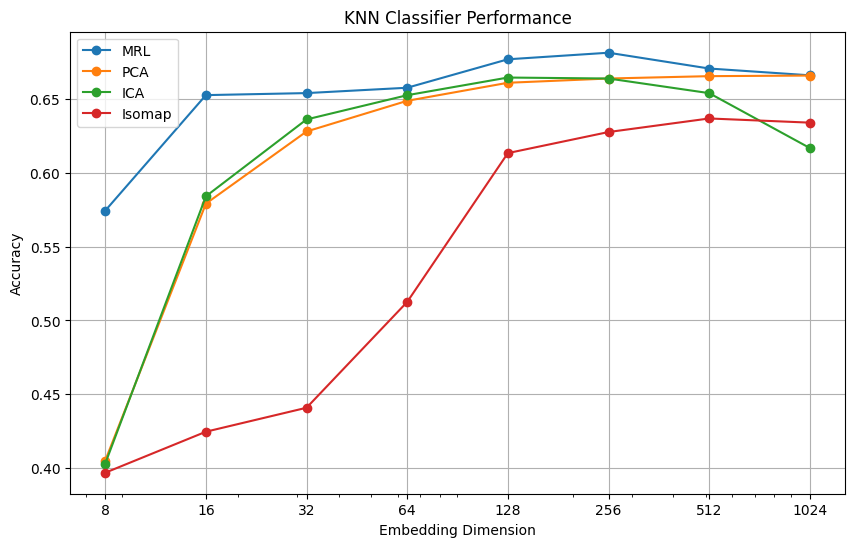

In [ ]:
import matplotlib.pyplot as plt

array_of_dicts = [results_cutoff, results_pca, results_ica, results_isomap]
method_names = ['MRL', 'PCA', 'ICA', 'Isomap']

plt.figure(figsize=(10, 6))
for idx, method_dict in enumerate(array_of_dicts):
    cur_dict = method_dict['KNN']
    dimensions = []
    accuracies = []
    for dim, accuracy in cur_dict.items():
        dimensions.append(dim)
        accuracies.append(accuracy)
    sorted_pairs = sorted(zip(dimensions, accuracies))
    x = [dim for dim, acc in sorted_pairs]
    y = [acc for dim, acc in sorted_pairs]
    plt.plot(x, y, 'o-', label=f"{method_names[idx]}")

plt.title('KNN Classifier Performance')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(x, labels=x)
plt.legend()
plt.grid(True)
plt.show()

Instrinsic dimensionality estimation

In [1]:
def load_embeddings(load_path):
    """Load embeddings from .npz file"""
    data = np.load(load_path, allow_pickle=True)
    
    # Reconstruct dictionary with original dimension keys
    embeddings = {
        int(key.split('_')[1]): data[key]
        for key in data.files
        if key.startswith('dim_')
    }
    
    return {
        'embeddings': embeddings,
        'labels': data['labels'],
        'nesting_list': data['nesting_list'].tolist()
    }

In [2]:
import numpy as np
emb_dict = load_embeddings('data/embeddings/embeddings.npz')

val_emb = emb_dict['embeddings']
val_labels = emb_dict['labels']
nesting_list = emb_dict['nesting_list']

In [14]:
from sklearn.base import clone
from tqdm import tqdm

def estimate_intrinsic_dimensionality(X_dict, estimators):
    results = {}
    for est_name, est in tqdm(estimators.items(), desc="Estimators"):
        est_results = {}
        print(f"\nProcessing {est_name}...")
        
        for emb_dim, X in tqdm(X_dict.items(), desc="Datasets", leave=False):
            print(f"Doing {emb_dim}...")
            try:
                current_est = clone(est)
                current_est.fit(X)
                
                if hasattr(current_est, 'dimension_'):
                    est_results[emb_dim] = current_est.dimension_
                    print(f" and results if {current_est.dimension_}\n")
                else:
                    est_results[emb_dim] = None
                    print(f"Warning: {est_name} has no 'dimension_' attribute for {emb_dim}")
                    
            except Exception as e:
                print(f"Error processing {emb_dim} with {est_name}: {str(e)}")
                est_results[emb_dim] = None
        
        results[est_name] = est_results
    
    return results

In [15]:
from skdim.id import MLE, FisherS, DANCo, TwoNN

estimators = {
    # 'MLE': MLE(),
    # 'FisherS': FisherS(),
    # 'DANCo': DANCo(),
    'TwoNN': TwoNN()
}

results = estimate_intrinsic_dimensionality(val_emb, estimators)
print("Estimated dimensions:", results)

Estimators:   0%|          | 0/1 [00:00<?, ?it/s]


Processing TwoNN...


Doing 8...


 and results if 5.892745024688343

Doing 16...


 and results if 8.101596705434723

Doing 32...


 and results if 10.205058341488291

Doing 64...


 and results if 12.13489734181948

Doing 128...


 and results if 13.1955489809504

Doing 256...


 and results if 14.477237789571536

Doing 512...


 and results if 15.669993869950977

Doing 1024...


 and results if 16.248564913233455

Doing 2048...


Estimators: 100%|██████████| 1/1 [18:49<00:00, 1129.51s/it]

 and results if 16.692966123924883

Estimated dimensions: {'TwoNN': {8: 5.892745024688343, 16: 8.101596705434723, 32: 10.205058341488291, 64: 12.13489734181948, 128: 13.1955489809504, 256: 14.477237789571536, 512: 15.669993869950977, 1024: 16.248564913233455, 2048: 16.692966123924883}}


In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_dimension_comparison(results_dict, method_name, nesting_dims):
    df = pd.DataFrame(results_dict).T
    plt.figure(figsize=(10, 6))
    for clf in df.index:
        plt.plot(df.columns, df.loc[clf], marker='o', label=clf)
    plt.title(f'Estimator --- {method_name}')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Intrinsic Dimensionality')
    plt.xscale('log')
    plt.xticks(nesting_dims, labels=nesting_dims)
    plt.legend()
    plt.grid(True)
    plt.show()

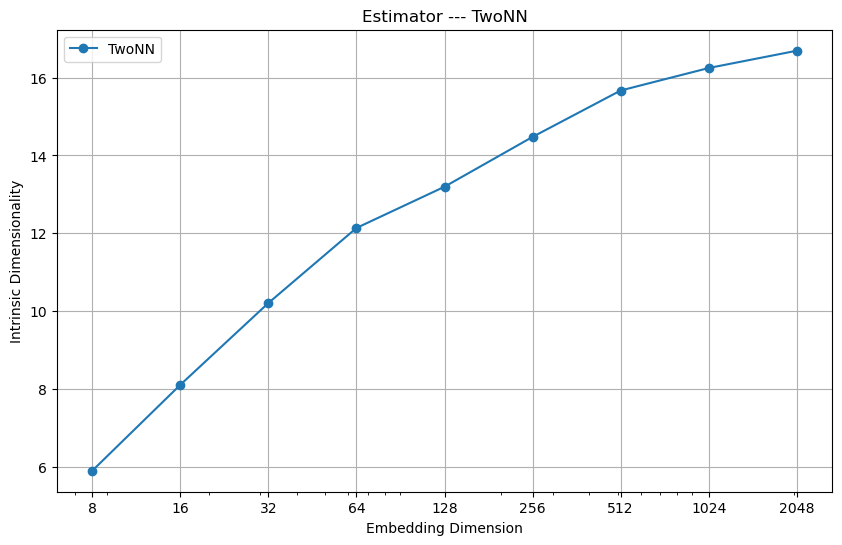

In [17]:
plot_dimension_comparison(results, 'TwoNN', nesting_list)

In [18]:
estimators = {
    'MLE': MLE(),
    # 'FisherS': FisherS(),
    # 'DANCo': DANCo(),
    # 'TwoNN': TwoNN()
}

results = estimate_intrinsic_dimensionality(val_emb, estimators)
print("Estimated dimensions:", results)

Estimators:   0%|          | 0/1 [00:00<?, ?it/s]


Processing MLE...


Doing 8...


 and results if 0.0

Doing 16...


 and results if 0.0

Doing 32...


 and results if 0.0

Doing 64...


 and results if 0.0

Doing 128...


 and results if 0.0

Doing 256...


 and results if 0.0

Doing 512...


 and results if 0.0

Doing 1024...


 and results if 0.0

Doing 2048...


Estimators: 100%|██████████| 1/1 [01:46<00:00, 106.33s/it]

 and results if 0.0

Estimated dimensions: {'MLE': {8: 0.0, 16: 0.0, 32: 0.0, 64: 0.0, 128: 0.0, 256: 0.0, 512: 0.0, 1024: 0.0, 2048: 0.0}}


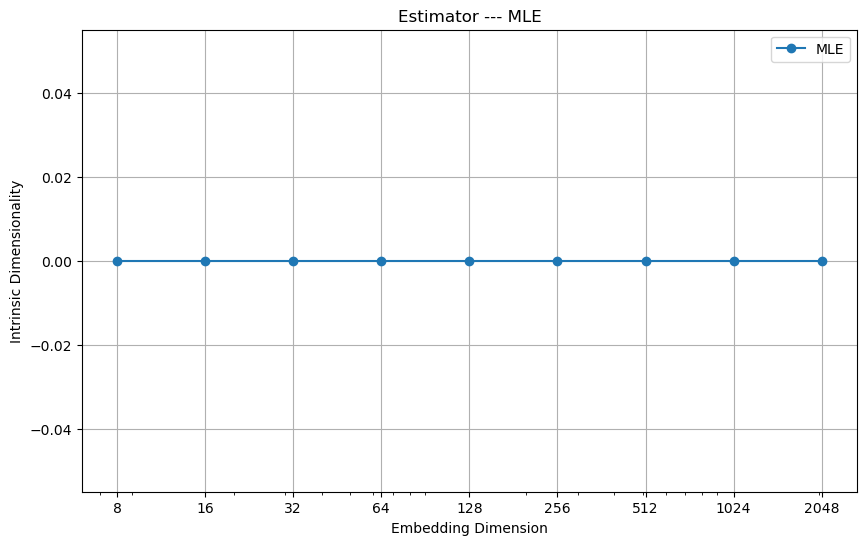

In [19]:
plot_dimension_comparison(results, 'MLE', nesting_list)

In [20]:
estimators = {
    # 'MLE': MLE(),
    'FisherS': FisherS(),
    # 'DANCo': DANCo(),
    # 'TwoNN': TwoNN()
}

results = estimate_intrinsic_dimensionality(val_emb, estimators)
print("Estimated dimensions:", results)

Estimators:   0%|          | 0/1 [00:00<?, ?it/s]


Processing FisherS...


Doing 8...


 and results if 6.77747670085153

Doing 16...


 and results if 8.491574358075274

Doing 32...


 and results if 8.716901603099224

Doing 64...


 and results if 8.700024478356147

Doing 128...


 and results if 7.558683958599385

Doing 256...


 and results if 8.639844012265275

Doing 512...


 and results if 8.629122839470652

Doing 1024...


 and results if 8.618641331096562

Doing 2048...


Estimators: 100%|██████████| 1/1 [11:05<00:00, 665.13s/it]

 and results if 8.613890668986302

Estimated dimensions: {'FisherS': {8: 6.77747670085153, 16: 8.491574358075274, 32: 8.716901603099224, 64: 8.700024478356147, 128: 7.558683958599385, 256: 8.639844012265275, 512: 8.629122839470652, 1024: 8.618641331096562, 2048: 8.613890668986302}}


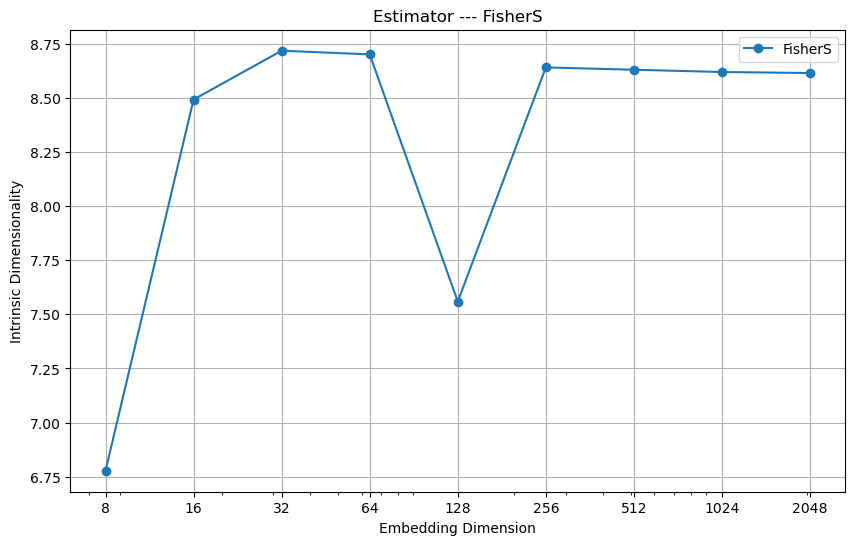

In [21]:
plot_dimension_comparison(results, 'FisherS', nesting_list)